# BOOTSTRAP BONDS TO CREATE A ZERO CURVE

In this notebook I show how you can exactly refit the implied zero curve from bond prices using a piecewise flat curve.

In [1]:
import datetime as dt
import pandas as pd

In [2]:
from financepy.utils import *
from financepy.products.bonds import *
from financepy.market.curves import *

####################################################################
# FINANCEPY BETA Version 0.200 - This build:  14 Jul 2021 at 13:18 #
# **** NEW PEP8 COMPLIANT VERSION -- PLEASE UPDATE YOUR CODE  **** #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



## Load Bond Data

I have downloaded some bond price data from the UK DMO

In [3]:
bondDataFrame = pd.read_csv('./data/giltbondprices.txt', sep='\t')

We'll use mid-market prices for our analysis

In [4]:
bondDataFrame['mid'] = 0.5*(bondDataFrame['bid'] + bondDataFrame['ask'])

We need to use UK bond conventions

In [5]:
accrual_type, frequencyType, settlementDays, spot_days, cal = \
get_bond_market_conventions(BondMarkets.UNITED_KINGDOM)

In [6]:
frequencyType

<FrequencyTypes.SEMI_ANNUAL: 2>

In [7]:
today = Date(18,9,2012)
settlement_date = today.add_weekdays(settlementDays)
print("Settles:", settlement_date)

Settles: 19-SEP-2012


In [8]:
bonds = []
clean_prices = []

In [9]:
for index, bondRow in bondDataFrame.iterrows():

    date_string = bondRow['maturity']
    matDatetime = dt.datetime.strptime(date_string, '%d-%b-%y')
    maturityDt = from_datetime(matDatetime)
    issueDt = Date(maturityDt._d, maturityDt._m, 2000)
    coupon = bondRow['coupon']/100.0
    bond = Bond(issueDt, maturityDt, coupon, frequencyType, accrual_type)
    clean_price = bondRow['mid']
    
    bonds.append(bond)
    clean_prices.append(clean_price)

## Bootstrapping the Bond Prices

We pass the bond prices and bonds and the bootstrap is done automatically

In [10]:
bondCurve = BondZeroCurve(settlement_date, bonds, clean_prices)

Let's just check that this curve reprices the bond

In [11]:
for clean_price, bond in zip(clean_prices,bonds):
    fittedPrice = bond.clean_price_from_discount_curve(settlement_date, bondCurve)
    diff = fittedPrice - clean_price
    print("Market: %10.6f   Fitted: %10.6f   Diff: %10.7f"% (clean_price,fittedPrice,diff))

Market: 101.995000   Fitted: 101.995000   Diff: -0.0000000
Market: 107.920000   Fitted: 107.920000   Diff:  0.0000000
Market: 102.975000   Fitted: 102.975000   Diff:  0.0000000
Market: 109.355000   Fitted: 109.355000   Diff: -0.0000000
Market: 105.625000   Fitted: 105.625000   Diff: -0.0000000
Market: 112.980000   Fitted: 112.980000   Diff:  0.0000000
Market: 124.470000   Fitted: 124.470000   Diff:  0.0000000
Market: 104.980000   Fitted: 104.980000   Diff:  0.0000000
Market: 113.495000   Fitted: 113.495000   Diff:  0.0000000
Market: 138.570000   Fitted: 138.570000   Diff:  0.0000002
Market: 121.790000   Fitted: 121.790000   Diff:  0.0000000
Market: 121.345000   Fitted: 121.345000   Diff:  0.0000003
Market: 116.815000   Fitted: 116.815000   Diff:  0.0000000
Market: 124.300000   Fitted: 124.300000   Diff: -0.0000000
Market: 117.375000   Fitted: 117.375000   Diff:  0.0000000
Market: 152.930000   Fitted: 152.930000   Diff:  0.0000000
Market: 117.695000   Fitted: 117.695000   Diff:  0.00000

What does the zero rate curve look like

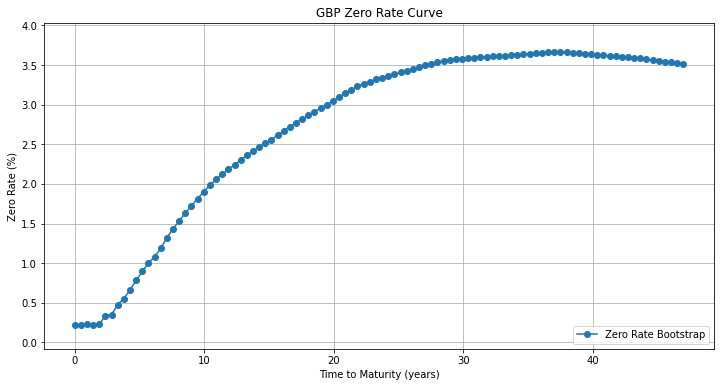

In [12]:
bondCurve.plot("GBP Zero Rate Curve")

## Forward Curve

How about the continuously compounded forwards. This gives us a detailed view on the term structure implied by the bond prices.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
times = np.linspace(0,10,2000)

In [15]:
fwds = bondCurve.fwd(times)

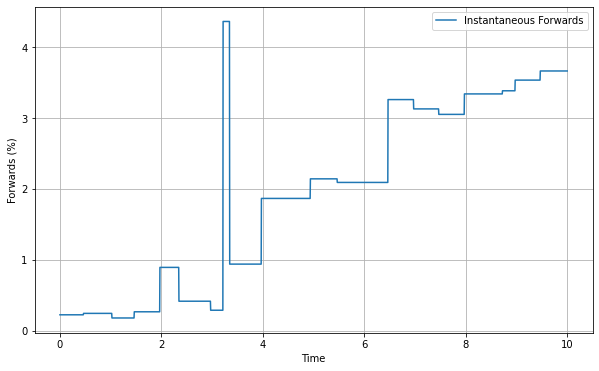

In [16]:
plt.figure(figsize=(10,6))
plt.plot(times,fwds*100, label="Instantaneous Forwards")
plt.xlabel("Time")
plt.ylabel("Forwards (%)")
plt.legend()
plt.grid()

Looks like there is some anomaly or mispricing around 3 years. As it does not last for long, it is probably not significant. 

Copyright (c) 2019, Dominic O'Kane 